# 3. Reconstruct using inverse Abel transform

In this notebook, we will use absorbance and inverse Abel transform to compute the concentration field assuming axial symmetry.

First, we should have run the following notebooks:
- `1 Preprocessing` to extract and denoise absorbance data.
- `2 Integrate` to measure the mass (minus probe shadow).

First we import Python modules and define some paraemters.

In [1]:
# Python imports
import numpy as np

from skimage.transform import rotate

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit

from abel.basex import basex_transform

In [2]:
# Hyper parameters

# pixels per cm
pxpcm = 367

# Time step between images (min)
dt = 1.

# Molar extinction coefficient (cm^-1 L/mol)
epsilon = 2900.

# Methylene blue molar mass (g mol^-1)
M = 319.85

## Import fields

In [3]:
A = np.load('absorbance.npy')
mask = np.load('mask.npy')
im0 = np.load('im0.npy')
print(f"Time steps (including time 0): {A.shape[0]}")
print(f"Image dimensions (height, width): {A.shape[1:]}")

Time steps (including time 0): 10
Image dimensions (height, width): (1200, 1920)


## Find symmetry axis (note: no rotation)

Use `i_min` and `i_max` as relative min and max lines to consider for finding the symmetry axis.

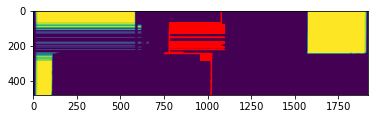

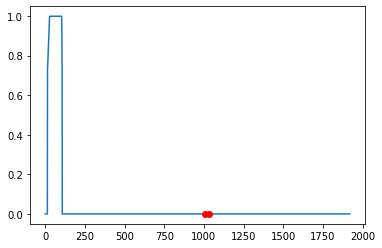

In [4]:
i_min = 0.3
i_max = 0.7

centres = []
ref = mask.copy()
ref[np.isnan(ref)] = 0
height, width = ref.shape

for i, line in enumerate(ref[int(i_min*height):int(i_max*height)]):
    line_hat = np.fft.rfft(line)
    conv = np.fft.irfft(line_hat**2)
    j = np.argmax(conv)
    if j<width//2:
        centres.append(width//2 + np.argmax(conv)//2)
    else:
        centres.append(np.argmax(conv)//2)
    
plt.imshow(ref[int(i_min*height):int(i_max*height)])
plt.plot(centres, list(range(len(centres))), 'r')
plt.show()

plt.plot(line)
plt.plot([centres[-1]-11, centres[-1]+11],[0,0], 'ro')
plt.show()

Change `offset` to specify where the pseudo-axial symmetry is located relative to the membrane.

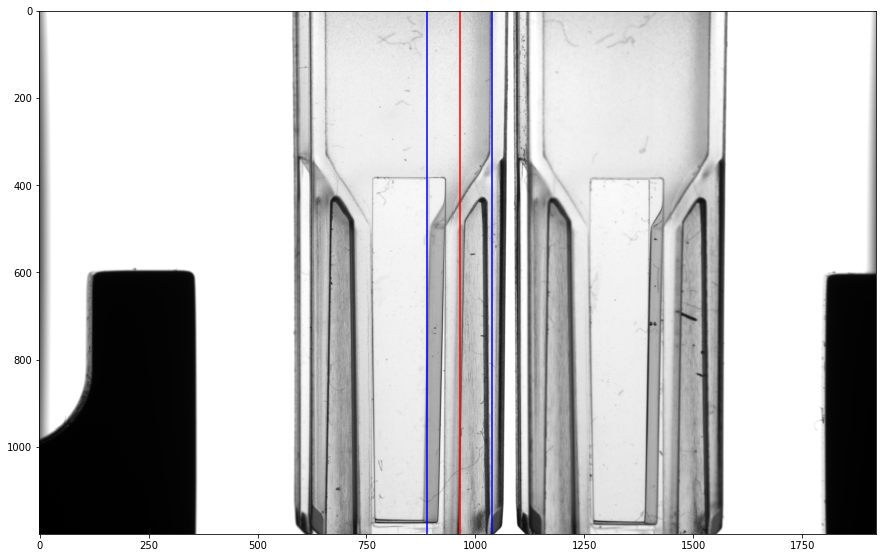

In [5]:
axis = int(np.average(centres))
offset = 75


plt.rcParams["figure.figsize"] = (15,40)
plt.imshow(im0, cmap='gray')
plt.plot([axis,axis], [0, len(ref)-1],'r')

plt.plot([axis+offset,axis+offset], [0, len(ref)-1],'b')
plt.plot([axis-offset,axis-offset], [0, len(ref)-1],'b')
plt.show()

## Concentration field reconstruction using inverse Abel transform

By convention, the inverse Abel transform considers the first column (left) as the symmetry axis, see https://pyabel.readthedocs.io/en/latest/abel.html#module-abel.basex. Therefore we split the image in two parts and include the axis in both:

**Note on thick and flat probes:** we remove some thickness using ``offset``

In [6]:
A_right = A[:,:,axis+offset:]
A_left = A[:,:,:axis+1-offset]

We are going to test the inverse Abel on one image first, selected at time `t`. 

We need to specify the size of the base functions, `sigma` (in pixels). If the absorbance image is already well smooth, then a small value (1) is ok. For noisy images, values larger than 1 can be used.

In [7]:
# Select absorbance image
t = 60

# Select base size
sigma = 1

# The result is in µg/mL

c_right = pxpcm*M*1e3/epsilon*basex_transform(A_right[t], sigma=sigma)
c_left = pxpcm*M*1e3/epsilon*basex_transform(np.flip(A_left[t], axis=1), sigma=sigma)

c = np.zeros_like(A[0])
c[:, axis+1+offset:] = c_right[:,1:]
c[:, :axis+1-offset] = np.flip(c_left, axis=1)

c[np.isnan(mask)] = np.nan

IndexError: index 60 is out of bounds for axis 0 with size 10

In [8]:
plt.rcParams["figure.figsize"] = (15,10)
plt.imshow(c, vmin=0, vmax=200)
plt.show()
print(np.nanmin(c), np.nanmax(c))

NameError: name 'c' is not defined

We should check artefacts like negative concentrations or high values near the edge.

### Concentration field

**Note on thick and flat probes:** Shadow is not accounted for.

If we are happy, let's do it for the whole stack!

In [9]:
c = np.empty_like(A)

for t in tqdm(range(len(A_left))):
    
    c_right = pxpcm*M*1e3/epsilon*basex_transform(A_right[t], sigma=sigma, verbose=False)
    c_left = pxpcm*M*1e3/epsilon*basex_transform(np.flip(A_left[t], axis=1), sigma=sigma, verbose=False)
    
    c_temp = np.zeros_like(A[0])
    c_temp[:, axis+1+offset:] = c_right[:,1:]
    c_temp[:, :axis+1-offset] = np.flip(c_left, axis=1)
    c_temp[np.isnan(mask)] = 0
    c_temp[c_temp<0] = 0
    c[t] = c_temp

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]


## Concentration map survey

In [10]:
from ipywidgets import interactive
import ipywidgets as widgets

# Background frame

c[c<2] = np.nan

def map(t):
    plt.rcParams["figure.figsize"] = (15,15)
    figure, ax = plt.subplots()
    ax.imshow(im0, cmap='gray', vmin=0, vmax=1)
    im = ax.imshow(c[t], cmap=plt.get_cmap('YlGnBu'), vmin=0, vmax=200)
    im.cmap.set_over('r')
    figure.colorbar(im, ax=ax)
    plt.show()


w2 = interactive(map, t=widgets.IntSlider(value=1,min=1,max=len(c)-1, continuous_update=False))
w2

interactive(children=(IntSlider(value=1, continuous_update=False, description='t', max=9, min=1), Output()), _…

In [11]:
# Save concentration slice for later use
#np.save('c_20min', c[20])
#np.save('c_60min', c[60])
#np.save('c_120min', c[120])
#np.save('c_5ug', c[42])

IndexError: index 30 is out of bounds for axis 0 with size 10

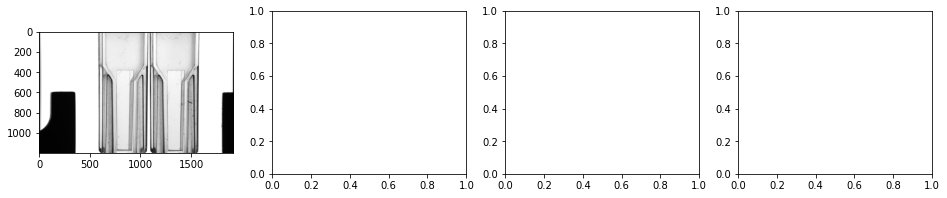

In [12]:
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = (16,3)
figure, ax = plt.subplots(nrows=1, ncols=4)
plt.rcParams['figure.dpi'] = 300

ax[0].imshow(im0, cmap='gray', vmin=0, vmax=1)
ax[0].imshow(c[30], cmap='YlGnBu', vmin=0, vmax=200)
rect = patches.Rectangle([10, 500], pxpcm/2, 20, linewidth=0, edgecolor='r', facecolor='k')
ax[0].add_patch(rect)
ax[0].axis('equal')
ax[0].axis('off')
ax[0].set_title('t = 30 min')

ax[1].imshow(im0, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(c[60], cmap=plt.get_cmap('YlGnBu'), vmin=0, vmax=200)
ax[1].axis('equal')
ax[1].axis('off')
ax[1].set_title('t = 60 min')

ax[2].imshow(im0, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(c[90], cmap=plt.get_cmap('YlGnBu'), vmin=0, vmax=200)
ax[2].axis('equal')
ax[2].axis('off')
ax[2].set_title('t = 90 min')

ax[3].imshow(im0, cmap='gray', vmin=0, vmax=1)
im = ax[3].imshow(c[119], cmap=plt.get_cmap('YlGnBu'), vmin=0, vmax=200)
im.cmap.set_over('r')
ax[3].axis('equal')
ax[3].axis('off')
ax[3].set_title('t = 120 min')

figure.colorbar(im, ax=ax[3], label='Concentration (µg/mL)')
plt.show()

In [ ]:
import matplotlib as mpl

# Build a discrete colorbar
cmap = mpl.colors.ListedColormap(["#7fcdbb", "#1d91c0", "#0c2c84"])
cmap.set_under('#eeeeee')
norm = mpl.colors.BoundaryNorm([2, 20, 100, 200], cmap.N) 


def map_q(t):
    plt.rcParams["figure.figsize"] = (15,15)
    figure, ax = plt.subplots()
    ax.imshow(im0, cmap='gray', vmin=0, vmax=1)
    im = ax.imshow(c[t], cmap=cmap, norm=norm)
    im.cmap.set_over('r')
    figure.colorbar(im, ax=ax)
    plt.show()


w3 = interactive(map_q, t=widgets.IntSlider(value=1,min=1,max=len(c)-1, continuous_update=False))
w3